# Hyperparameters Tuning with PyTorch (The Bible)

## Batch Normalization

In [1]:
from torchvision import datasets
import torch
data_folder = 'Desktop/data' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

100.0%


Extracting Desktop/data\FashionMNIST\raw\train-images-idx3-ubyte.gz to Desktop/data\FashionMNIST\raw



100.0%


Extracting Desktop/data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to Desktop/data\FashionMNIST\raw



100.0%


Extracting Desktop/data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to Desktop/data\FashionMNIST\raw



100.0%

Extracting Desktop/data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to Desktop/data\FashionMNIST\raw



In [2]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [3]:
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Without BatchNormalization

In [5]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/(255*10000)
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

from torch.optim import SGD, Adam
def get_model():
    class neuralnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input_to_hidden_layer = nn.Linear(784,1000)
            self.hidden_layer_activation = nn.ReLU()
            self.hidden_to_output_layer = nn.Linear(1000,10)
        def forward(self, x):
            x = self.input_to_hidden_layer(x)
            x1 = self.hidden_layer_activation(x)
            x2= self.hidden_to_output_layer(x1)
            return x2, x1
    model = neuralnet().to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)[0]
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)[0]
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [6]:
def get_data():     
    train = FMNISTDataset(tr_images, tr_targets)     
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [7]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)[0]
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [8]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [9]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(10):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9


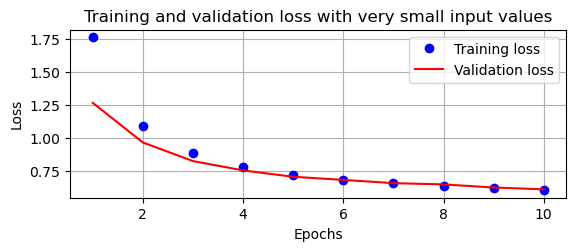

C:\Users\tommy\AppData\Local\Temp\ipykernel_28000\3938428673.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


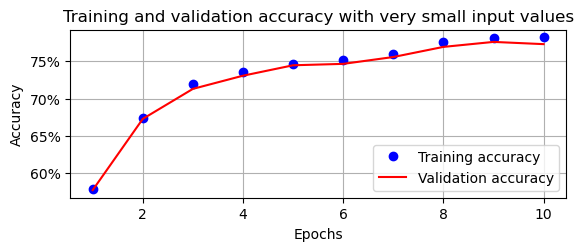

In [11]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with very small input values')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with very small input values')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

Text(0.5, 1.0, "Hidden layer node values' distribution")

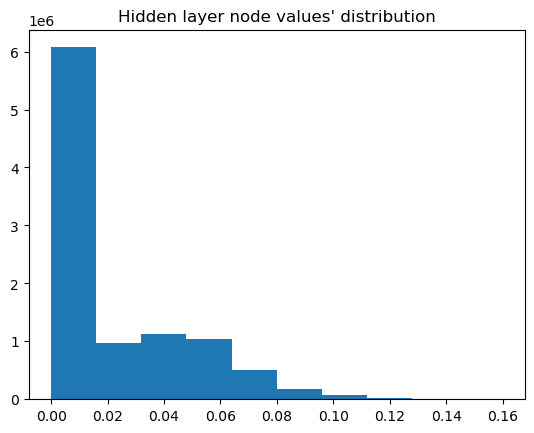

In [12]:
plt.hist(model(x)[1].cpu().detach().numpy().flatten())
plt.title("Hidden layer node values' distribution")

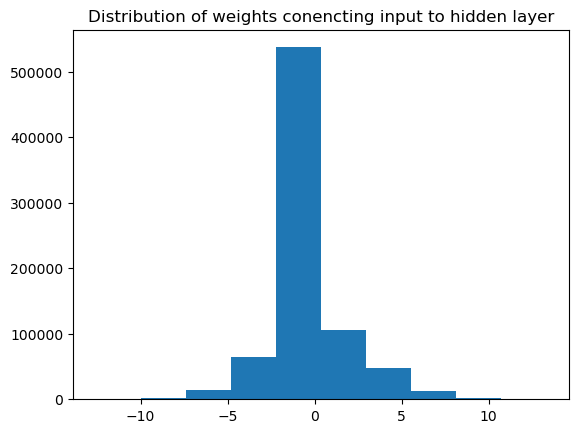

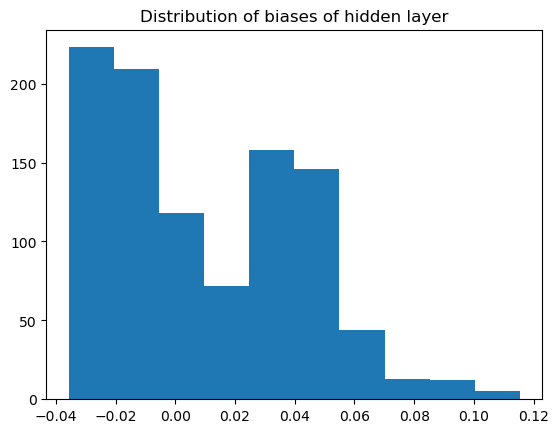

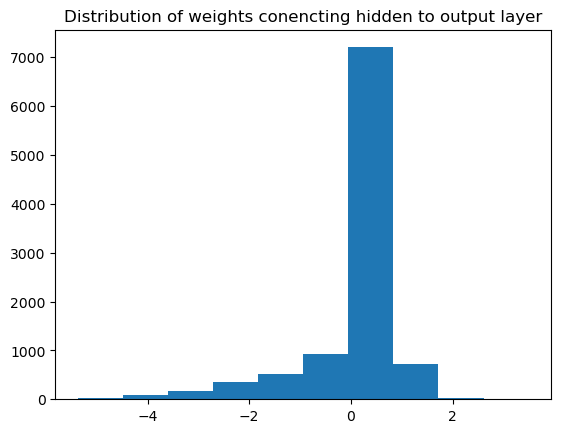

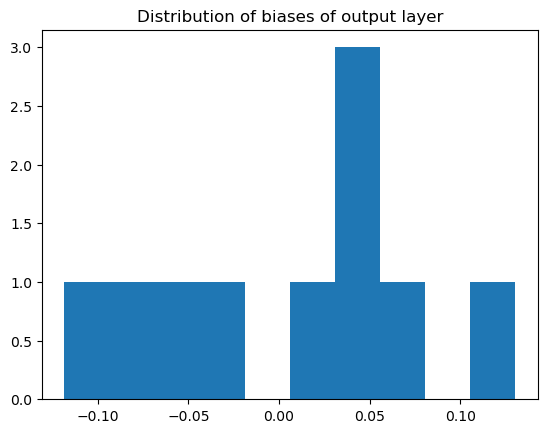

In [13]:
for ix, par in enumerate(model.parameters()):
    
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        #plt.xlim(-2,2)
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        #plt.xlim(-2,2)
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        #plt.xlim(-2,2)
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        #plt.xlim(-2,2)
        plt.title('Distribution of biases of output layer')
        plt.show()  

### With BatchNormalization

In [14]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/(255*10000)
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

from torch.optim import SGD, Adam
def get_model():
    class neuralnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input_to_hidden_layer = nn.Linear(784,1000)
            self.batch_norm = nn.BatchNorm1d(1000)### <------ THIS
            self.hidden_layer_activation = nn.ReLU()
            self.hidden_to_output_layer = nn.Linear(1000,10)
        def forward(self, x):
            x = self.input_to_hidden_layer(x)
            x0 = self.batch_norm(x)### <--- THIS
            x1 = self.hidden_layer_activation(x0)
            x2= self.hidden_to_output_layer(x1)
            return x2, x1
    model = neuralnet().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)[0]
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)[0]
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [15]:
def val_loss(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)[0]
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [16]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [17]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(10):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9


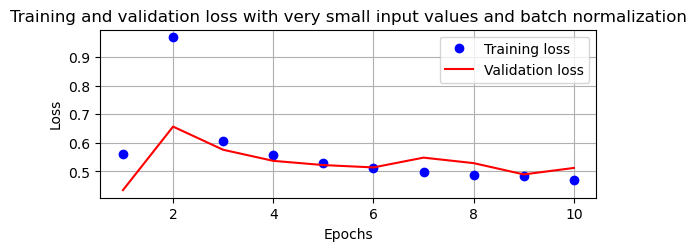

C:\Users\tommy\AppData\Local\Temp\ipykernel_28000\2469807820.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


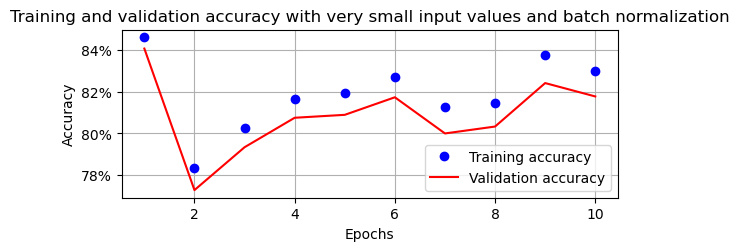

In [18]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with very small input values and batch normalization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with very small input values and batch normalization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

Text(0.5, 1.0, "Hidden layer node values' distribution with batch normalization")

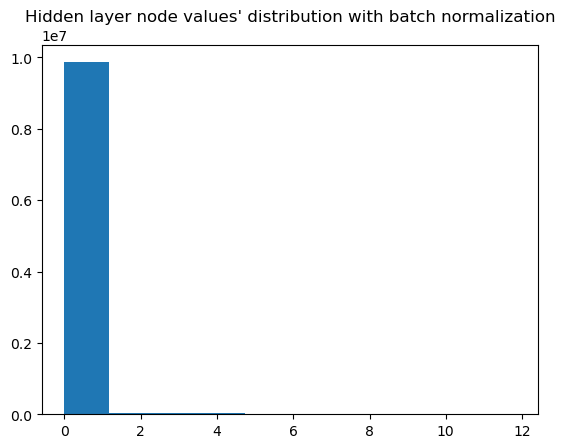

In [19]:
plt.hist(model(x)[1].cpu().detach().numpy().flatten())
plt.title("Hidden layer node values' distribution with batch normalization")

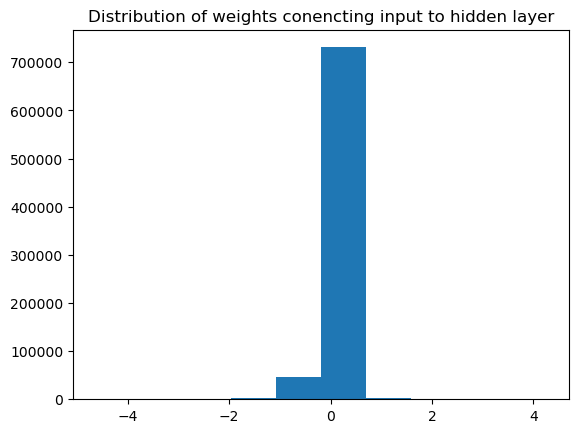

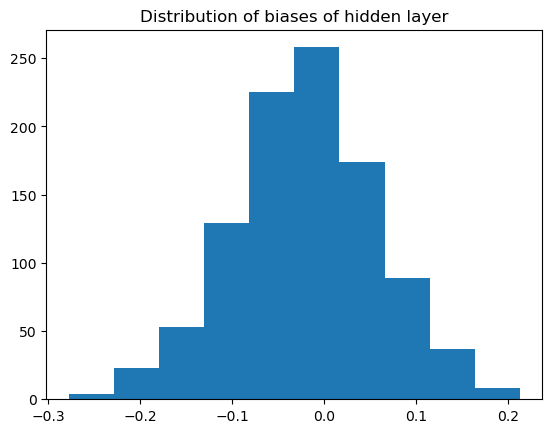

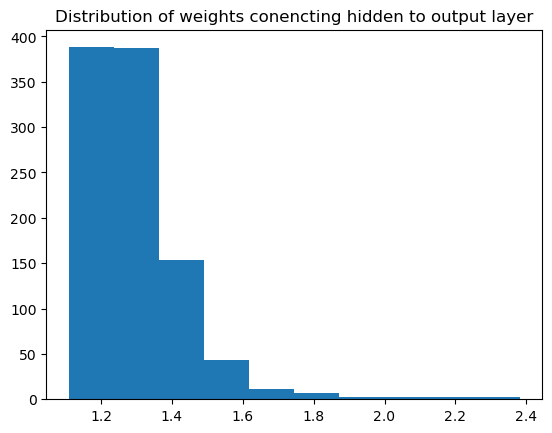

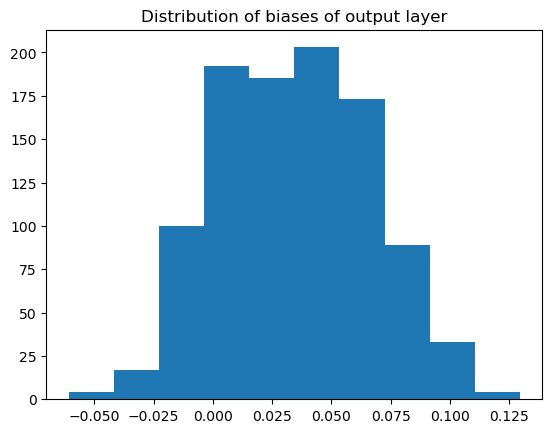

In [20]:
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        #plt.xlim(-2,2)
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        #plt.xlim(-2,2)
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        #plt.xlim(-2,2)
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        #plt.xlim(-2,2)
        plt.title('Distribution of biases of output layer')
        plt.show()  

# Varying Learning Rate on Scaled Data (/255)

### High Learning Rate lr=0.1

In [21]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-1)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    model.eval()
    # this is the same as @torch.no_grad 
    # at the top of function, only difference
    # being, grad is not computed in the with scope
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [22]:
def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets) 
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

In [23]:
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [24]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [25]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


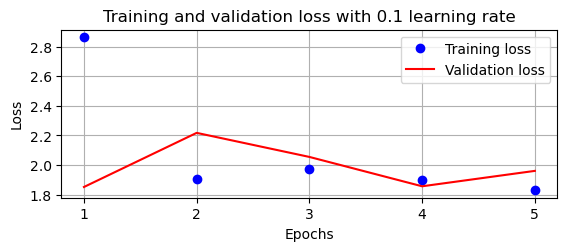

C:\Users\tommy\AppData\Local\Temp\ipykernel_28000\2651813370.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


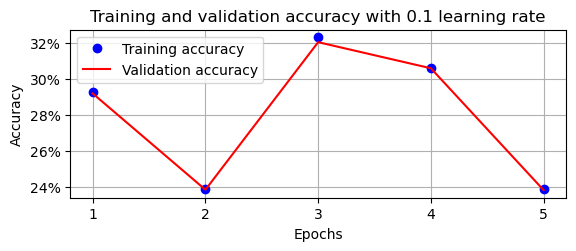

In [26]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with 0.1 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 0.1 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

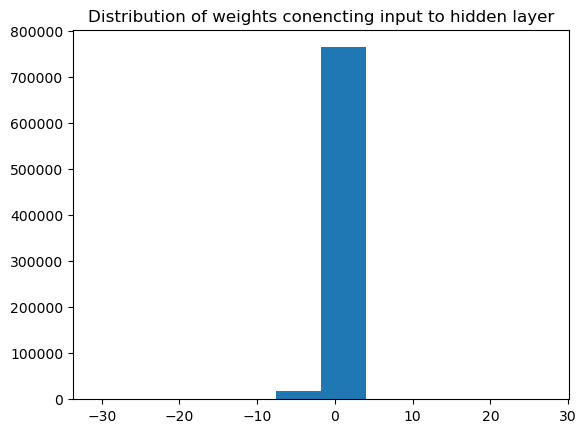

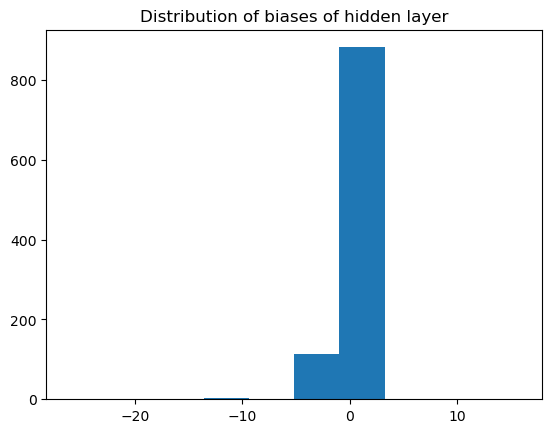

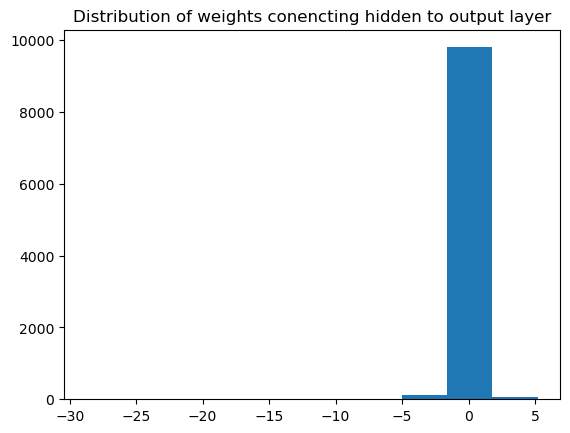

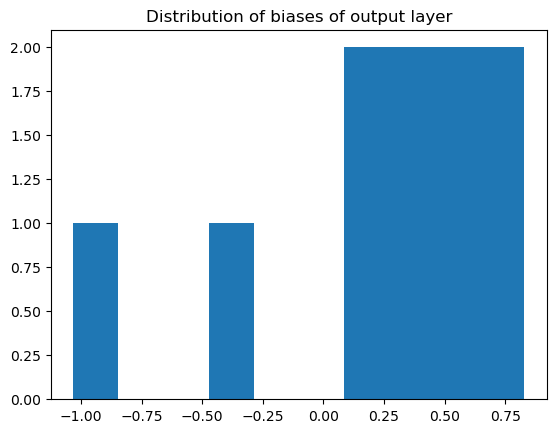

In [27]:
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of output layer')
        plt.show() 

### Medium Learning Rate lr=0.001

In [28]:
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [29]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [30]:


train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)



0
1
2
3
4


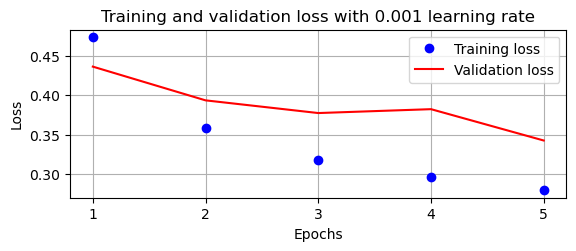

C:\Users\tommy\AppData\Local\Temp\ipykernel_28000\2649727376.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


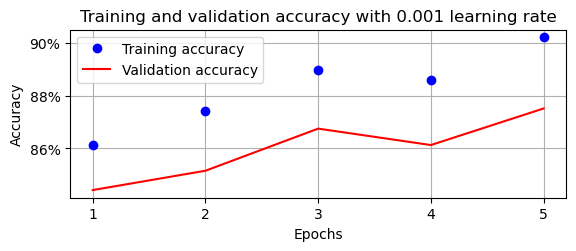

In [31]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with 0.001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 0.001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

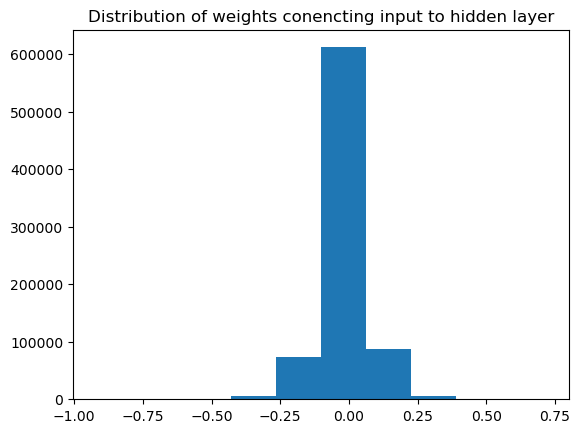

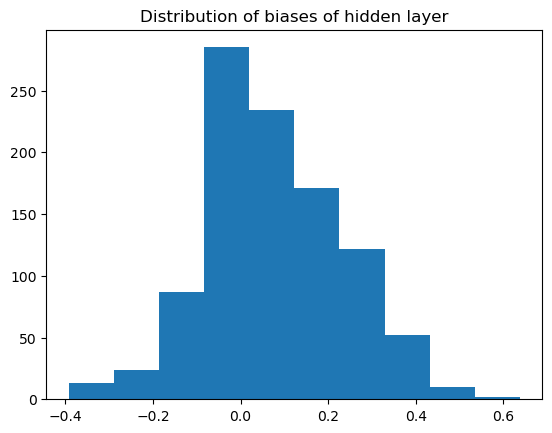

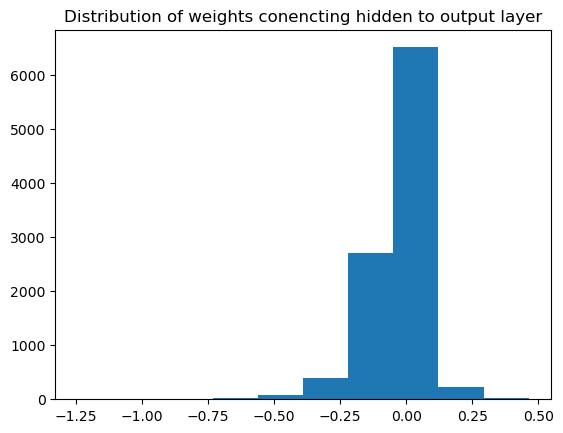

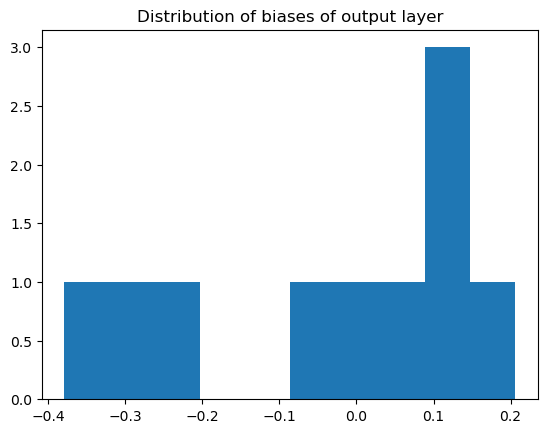

In [32]:
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of output layer')
        plt.show() 



### Low Learning Rate lr=0.00001

In [33]:
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-5)
    return model, loss_fn, optimizer 

In [34]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [35]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


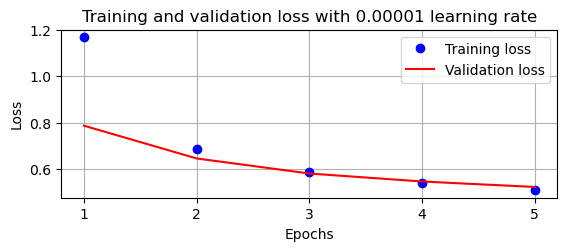

C:\Users\tommy\AppData\Local\Temp\ipykernel_28000\592690014.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


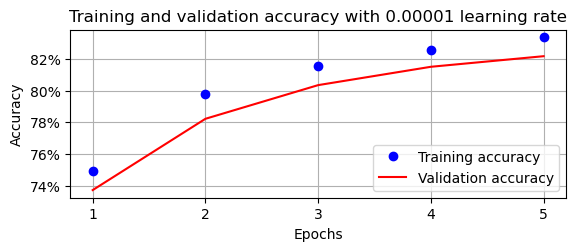

In [36]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with 0.00001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 0.00001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

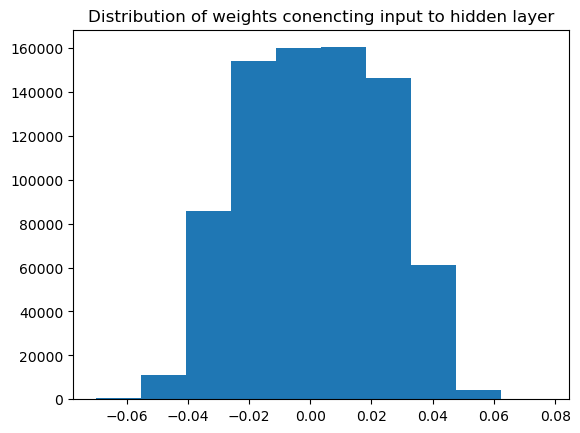

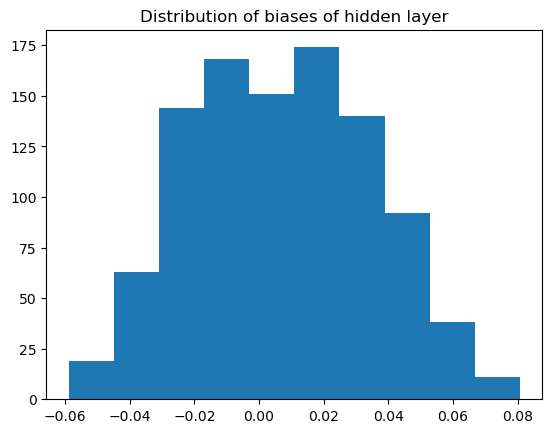

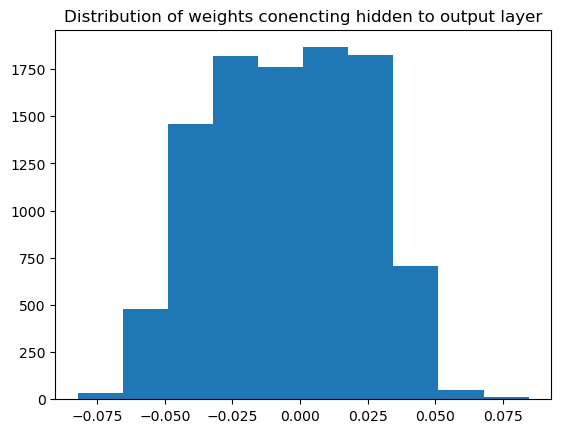

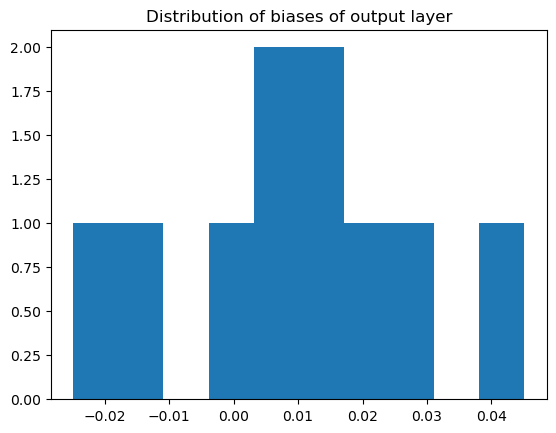

In [37]:
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of output layer')
        plt.show() 

## Using Lr Scheduler to automate during plateau phase

In [42]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1,28*28)/255
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    model.eval()
    # this is the same as @torch.no_grad 
    # at the top of function, only difference
    # being, grad is not computed in the with scope
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [43]:
def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets) 
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

In [44]:
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [45]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [46]:
from torch import optim
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 factor=0.5, 
                                                 patience=0, 
                                                 threshold = 0.001, 
                                                 verbose=True, 
                                                 min_lr = 1e-5, 
                                                 threshold_mode = 'abs'
                                                ) #<---- This is the implementation of the scheduler
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(10):
    #print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
        scheduler.step(validation_loss) #<-- Add this for the scheduler implementation
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00008: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00010: reducing learning rate of group 0 to 1.2500e-04.


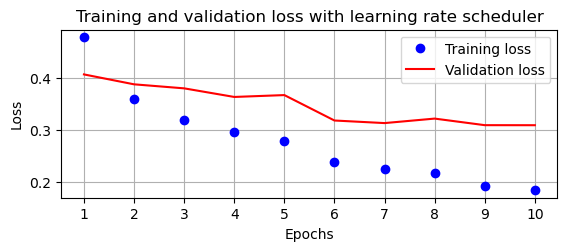

C:\Users\tommy\AppData\Local\Temp\ipykernel_28000\3577647813.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


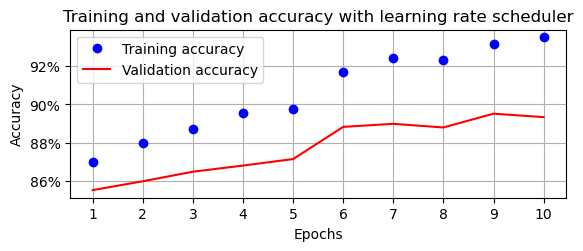

In [47]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with learning rate scheduler')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with learning rate scheduler')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

## Note:
### You can also variate the optimizer method 

## Impact of Dropout
### Dropout 0.25

In [48]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Dropout(0.25),################
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Dropout(0.25),################
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [49]:
def get_data():     
    train = FMNISTDataset(tr_images, tr_targets)     
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [50]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [51]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [52]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(10):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9


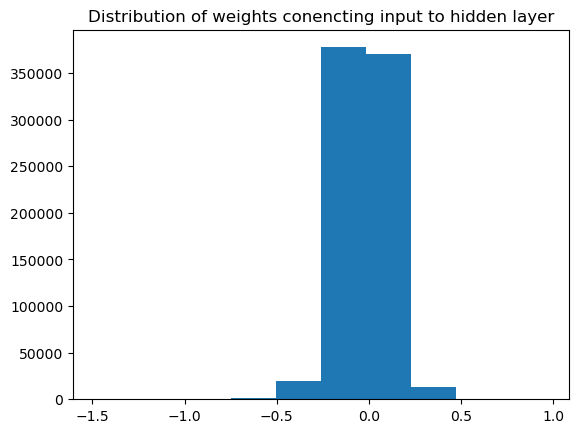

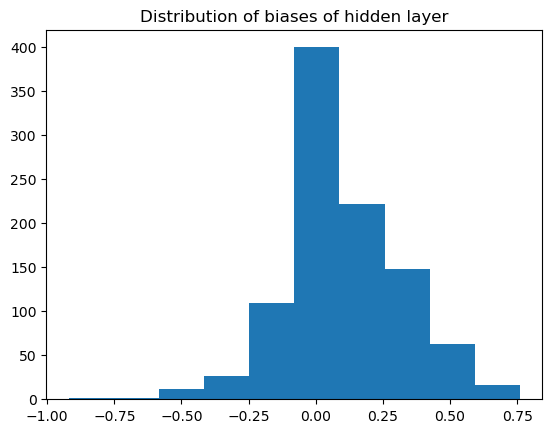

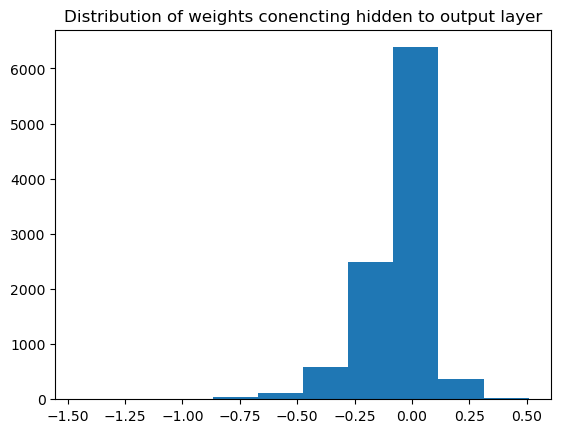

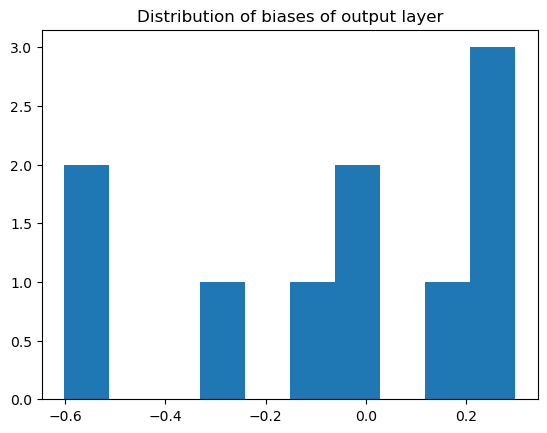

In [53]:
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        #plt.xlim(-2,2)
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        #plt.xlim(-2,2)
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        #plt.xlim(-2,2)
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        #plt.xlim(-2,2)
        plt.title('Distribution of biases of output layer')
        plt.show()  

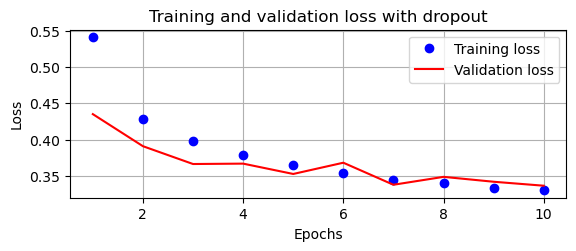

C:\Users\tommy\AppData\Local\Temp\ipykernel_28000\1983806637.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


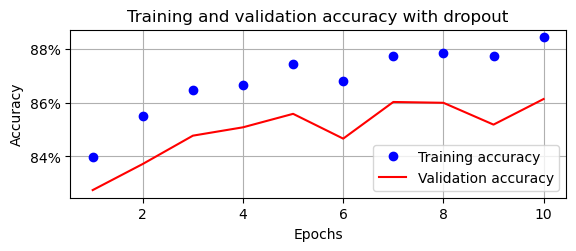

In [55]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with dropout')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with dropout')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

## Regularization

### L1 Regularization

In [56]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    l1_regularization = 0#############
    for param in model.parameters():
        l1_regularization += torch.norm(param,1) ############
    batch_loss = loss_fn(prediction, y) + 0.0001*l1_regularization ####################
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [57]:
trn_dl, val_dl = get_data()
model_l1, loss_fn, optimizer = get_model()

In [59]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(10):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model_l1, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model_l1)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model_l1)
        validation_loss = val_loss(x, y, model_l1)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9


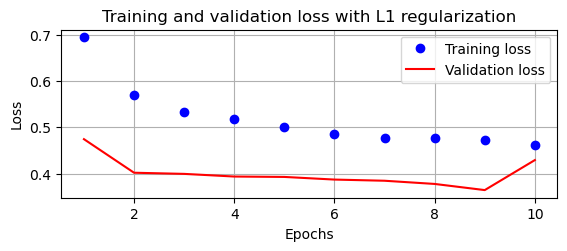

C:\Users\tommy\AppData\Local\Temp\ipykernel_28000\3160902832.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


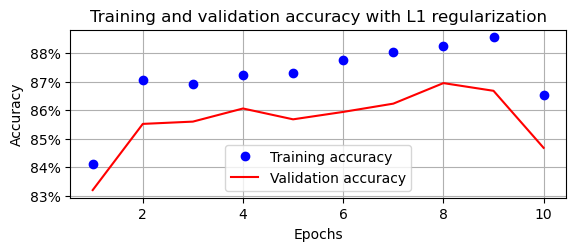

In [60]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with L1 regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with L1 regularization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

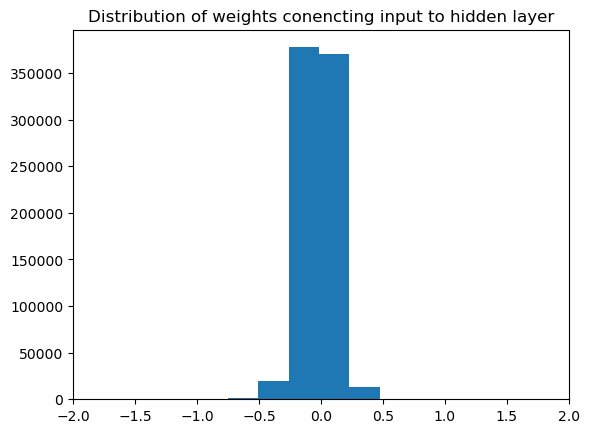

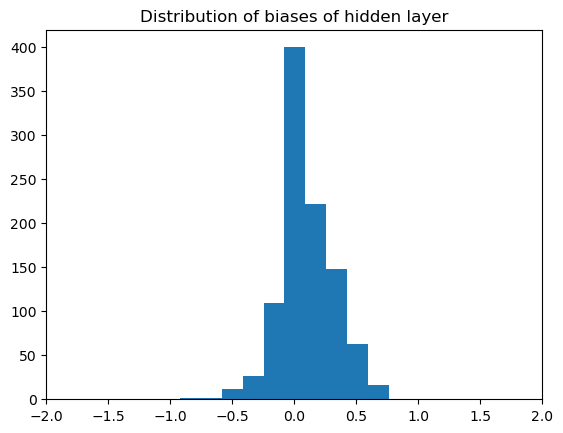

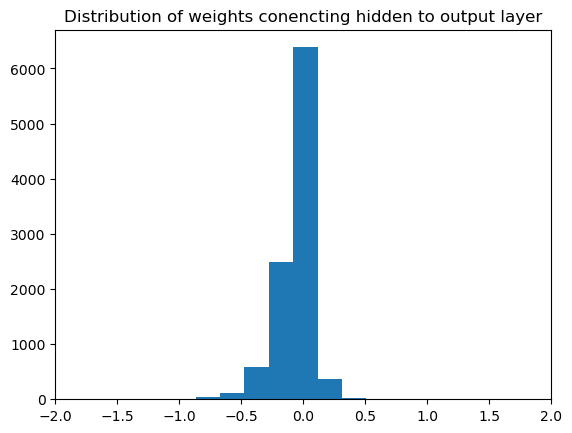

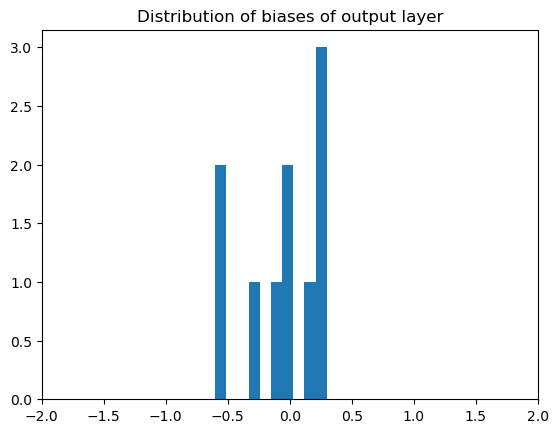

In [61]:
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.xlim(-2,2)
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.xlim(-2,2)
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.xlim(-2,2)
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.xlim(-2,2)
        plt.title('Distribution of biases of output layer')
        plt.show()  

### L2 Regularization

In [65]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    l2_regularization = 0###############
    for param in model.parameters():
        l2_regularization += torch.norm(param,2)##############
    batch_loss = loss_fn(prediction, y) + 0.01*l2_regularization#######################
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [66]:
trn_dl, val_dl = get_data()
model_l2, loss_fn, optimizer = get_model()

In [67]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(10):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model_l2, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model_l2)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model_l2)
        validation_loss = val_loss(x, y, model_l2)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9


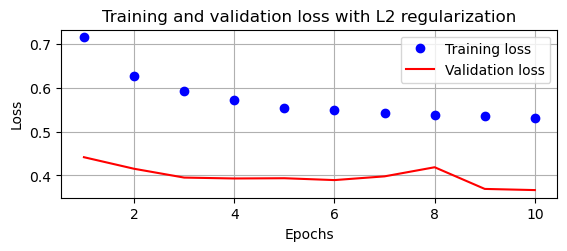

C:\Users\tommy\AppData\Local\Temp\ipykernel_28000\1175726064.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


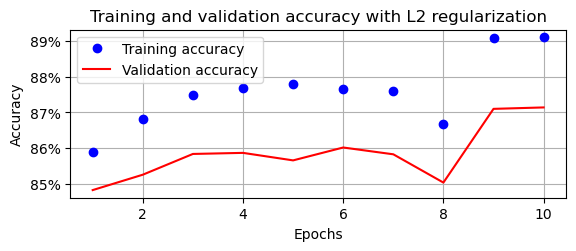

In [68]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with L2 regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with L2 regularization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

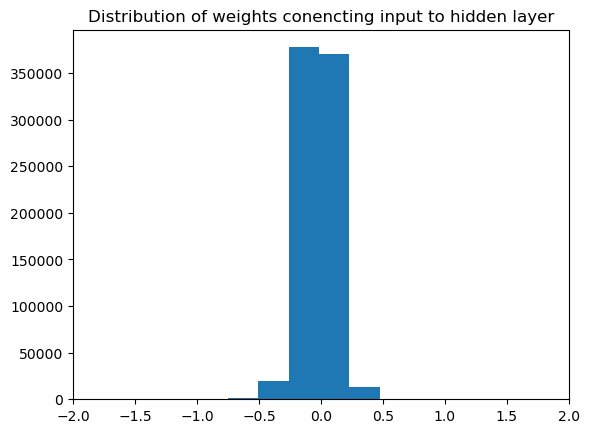

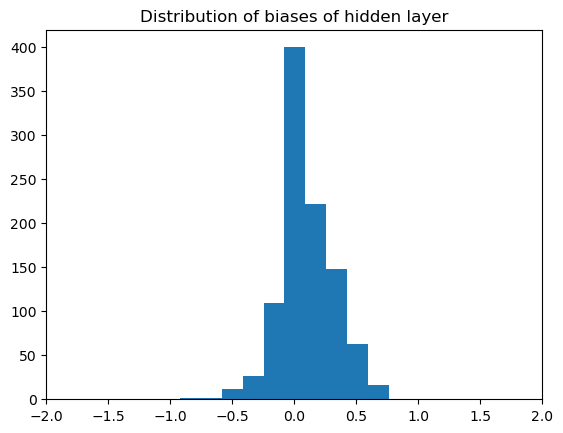

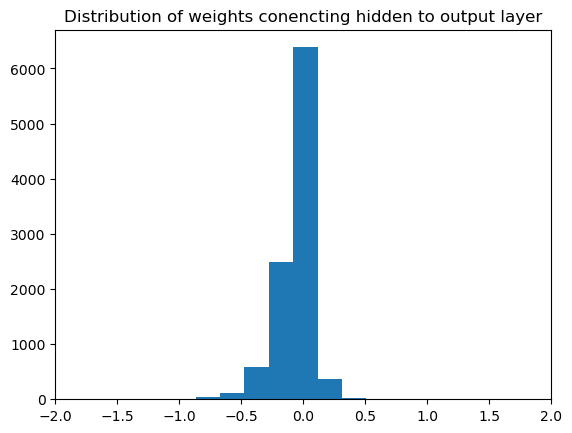

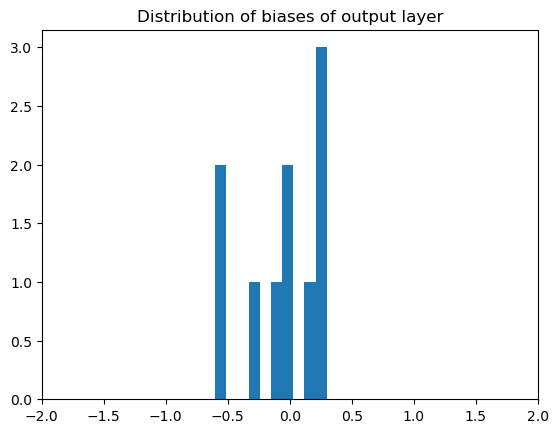

In [69]:
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.xlim(-2,2)
        plt.title('Distribution of weights conencting input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.xlim(-2,2)
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.xlim(-2,2)
        plt.title('Distribution of weights conencting hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.xlim(-2,2)
        plt.title('Distribution of biases of output layer')
        plt.show()  